<a href="https://colab.research.google.com/github/Funmiadebajo/GIS/blob/main/PS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring Shared Housing as a Solution to Intergenerational Homelessness in Camden City, Camden NJ**



According to Monarch Housing, (2024) Camden City with a poverty rate of 36%, contributed nearly 68% to the homeless population in New Jersey in the January 2024 Point-in-Time Counts. According to recent estimates, Camden County's unsheltered homeless count has surged, with more than 84% of the county's unsheltered individuals residing in Camden City alone.

Of particular concern is the demographic composition of Camden's homeless population, as 316 individuals fall within the 18 to 44 age range—a vibrant group whose potential contributions to economic development are hindered by the destabilizing effects of homelessness(Monarch Housing, 2024). The constant stress of survival in unstable housing situations leads to chronic physical and mental health conditions, low educational attainment, and difficulties in securing long-term employment (Shinn et al., 2005).

The Corporation for Supportive Housing (2015) estimated that without intervention, 50% of those experiencing homelessness for the first time will have additional episodes. There is therefore an urgent need for innovative and proactive "prevention-as-cure" approaches to address this crisis to alter the trajectory of homelessness for future generations significantly.


**Research Objective**
To explore the potential of formal shared housing program for single adults at risk of homelessness in Camden, NJ.

In [103]:
%%capture
!pip install geopandas==1.0.1
!pip install mapclassify
import seaborn as sns

In [88]:
pip install contextily

In [89]:
import os, zipfile #basics
import pandas as pd #data management
import matplotlib.pyplot as plt #vis

import geopandas as gpd #gis/maps: a sister of pandas; does the job;
#tho not as fancy-interactive as folium or leafmap https://geopandas.org/

import mapclassify #need for thematic map classification

import re
from matplotlib.colors import ListedColormap


#will display all output not just last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import files #to download from colab onto hd

#from google.colab import data_table
#data_table.enable_dataframe_formatter() #this enables spreadsheet view upon calling dataframe (without() )
from google.colab.data_table import DataTable
DataTable.max_columns = 250

In [90]:
#!python --version
gpd.__version__

'1.0.1'

#HOMELESSNESS: A VISIBLE INDICATOR OF URBAN POVERTY

Homelessness is one of the most visible indicators of urban poverty across America. While poverty and homelessness are closely linked, they are distinct issues. The U.S. Department of Housing and Urban Development (HUD) defines homelessness as individuals and families who lack a fixed, regular, and adequate nighttime residence. This includes those living in shelters, transitional Housing, or places not meant for human habitation (U.S. Department of Housing and Urban Development, 2019).

Intergenerational homelessness occurs when families that experience homelessness pass these conditions onto younger generations, creating a self-perpetuating cycle.
A large body of academic research shows that increasing housing costs is the most basic macroeconomic cause of homelessness. When median rents increase by $100, homelessness rates rise by nine percent; and about 74% of highly low-income renters pay above 50% of their income on rent. (Horowitz et al., 2023, National Alliance to End Homelessness, 2024).


# Causes of Homelessness in Camden County

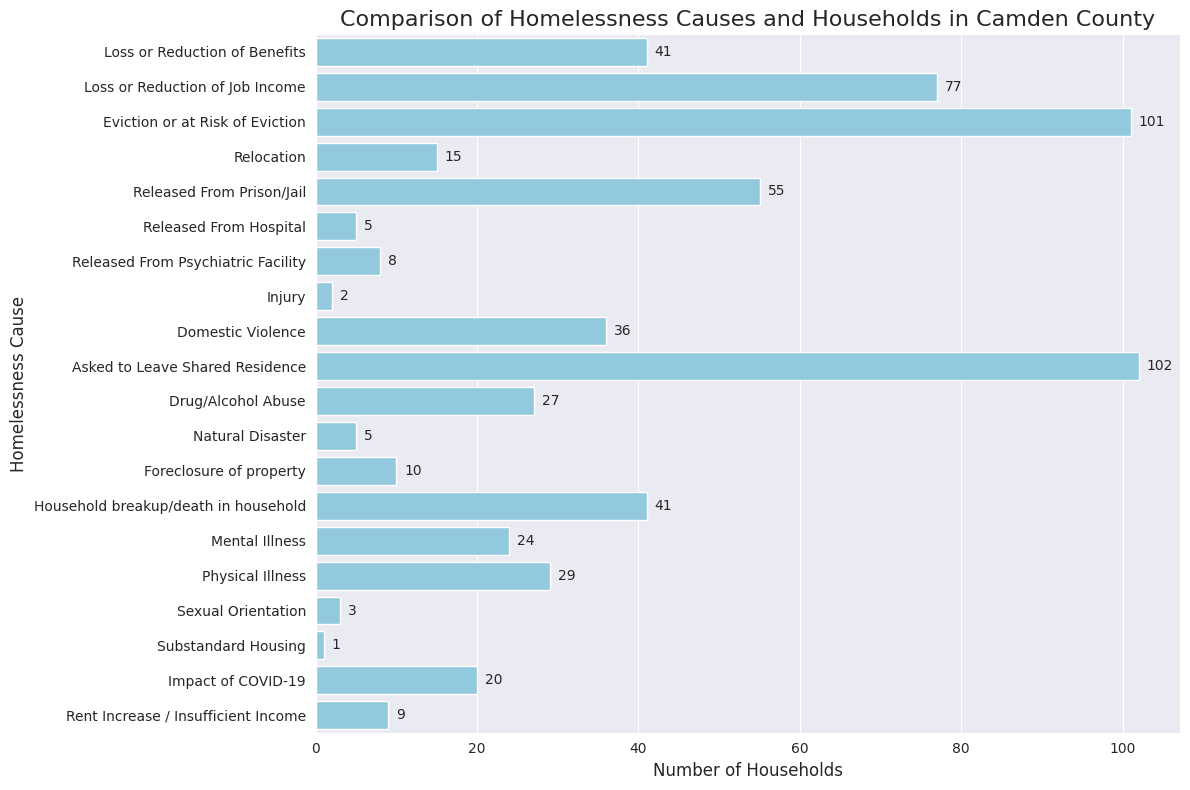

In [91]:
# Read the data from the provided URL
url = 'https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/inus%20condition1.xlsx'
data = pd.read_excel(url)

# Set up the figure size
plt.figure(figsize=(12, 8))

# Create a horizontal bar chart using Seaborn
sns.barplot(
    data=data,
    y='Homelessness Cause ',  # Causes on the Y-axis for better label alignment
    x='Households',
    color='skyblue'
)

# Add labels for each bar
for index, value in enumerate(data['Households']):
    plt.text(value + 1, index, f'{value}', va='center')  # Annotate each bar

# Customize the chart
plt.title('Comparison of Homelessness Causes and Households in Camden County', fontsize=16)
plt.xlabel('Number of Households', fontsize=12)
plt.ylabel('Homelessness Cause', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show();


Homelessness remains a significant challenge in Camden County, New Jersey, with ongoing debates about the origins of the homeless population. Some argue that many homeless individuals in Camden County are not originally from the area, yet evidence to support this claim is lacking. The 2024 Point-In-Time (PIT) count indicates that 244 of the homeless individuals counted in January 2024 were from Camden itself (Monarch Housing Associates, 2024).

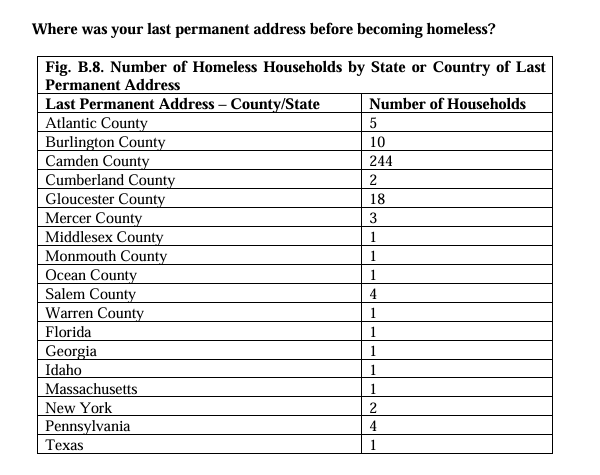

**Symbiotic Relationship Between Poverty and Homlessness across New Jersey Counties.**

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


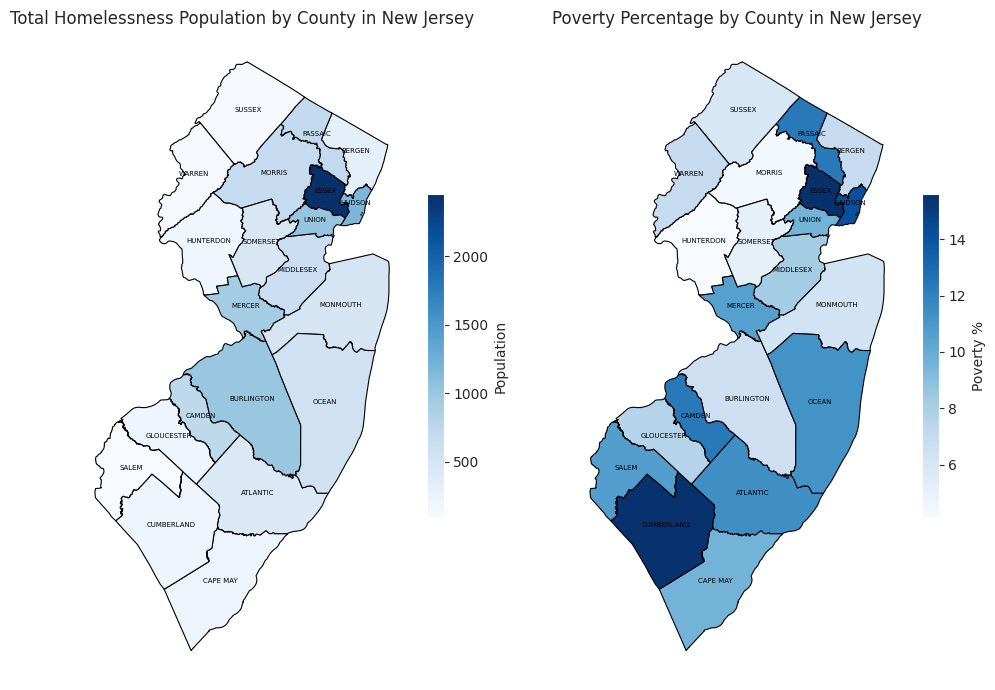

In [92]:


# Load New Jersey counties shapefile
url = "https://www2.census.gov/geo/tiger/TIGER2021/COUNTY/tl_2021_us_county.zip"
counties = gpd.read_file(url)
nj_counties = counties[counties['STATEFP'] == '34']  # Filter for NJ (FIPS code = 34)

# Load and clean Chronicity data
Chronicity = pd.read_excel('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/chronic.xlsx')
Chronicity['COUNTY'] = Chronicity['County'].str.upper().str.strip()  # Standardize County names

# Clean NJ counties data and prepare for merge
nj_counties['NAME'] = nj_counties['NAME'].str.replace("County", "").str.strip().str.upper()
nj_counties['COUNTY'] = nj_counties['NAME']

# Merge NJ counties with Chronicity data
njMerged = nj_counties.merge(Chronicity, on='COUNTY', how='outer', indicator=True)

# Ensure columns for plotting (Population and Poverty) are numeric
njMerged['population'] = pd.to_numeric(njMerged['population'], errors='coerce')
njMerged['poverty'] = pd.to_numeric(njMerged['poverty'], errors='coerce')

# Plot maps
fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharex=True, sharey=True)

# First Map - Population by County
njMerged.plot(
    ax=axes[0], column='population', cmap='Blues',
    linewidth=0.8, edgecolor='black', legend=True,
    legend_kwds={'shrink': 0.5, 'label': 'Population'}
)
axes[0].set_title('Total Homelessness Population by County in New Jersey', fontsize=12)
axes[0].set_axis_off()

# Add county names on the first map (Population by County)
for _, row in njMerged.iterrows():
    centroid = row['geometry'].centroid
    axes[0].text(centroid.x, centroid.y, row['COUNTY'], fontsize=5, ha='center', color='black')

# Second Map - Poverty Percentage by County
njMerged.plot(
    ax=axes[1], column='poverty', cmap='Blues',
    linewidth=0.8, edgecolor='black', legend=True,
    legend_kwds={'shrink': 0.5, 'label': 'Poverty %'}
)
axes[1].set_title('Poverty Percentage by County in New Jersey', fontsize=12)
axes[1].set_axis_off()

# Add county names on the second map (Poverty Percentage by County)
for _, row in njMerged.iterrows():
    centroid = row['geometry'].centroid
    axes[1].text(centroid.x, centroid.y, row['COUNTY'], fontsize=5, ha='center', color='black')

# Adjust layout and show the plot
plt.tight_layout()
plt.show();


### 5-Year Comparison of Total Homeless Population by Housing Situation across Camden County, New Jersey



On the night of January 23, 2024, a total of 743 persons in 619 households were experiencing homelessness in Camden County. This Table shows that Camden County has seen an overall increase of 110 identified persons
(17%) from 2020 to 2024; and a gradual increase in population of unsheltered homeless persons between 2021 and 2024. (Monarch Housing, 2024).

This chart visualises patterns and trends of homlessness types over a period of 5 years. It also provides evidence-based recommendations for Shared Housing as a prevention and cure for homelessness in Camden County.

Index(['Year', 'Emergency Shelter', 'Unsheltered', 'Transitional Housing',
       'Safe Haven', 'Total'],
      dtype='object')


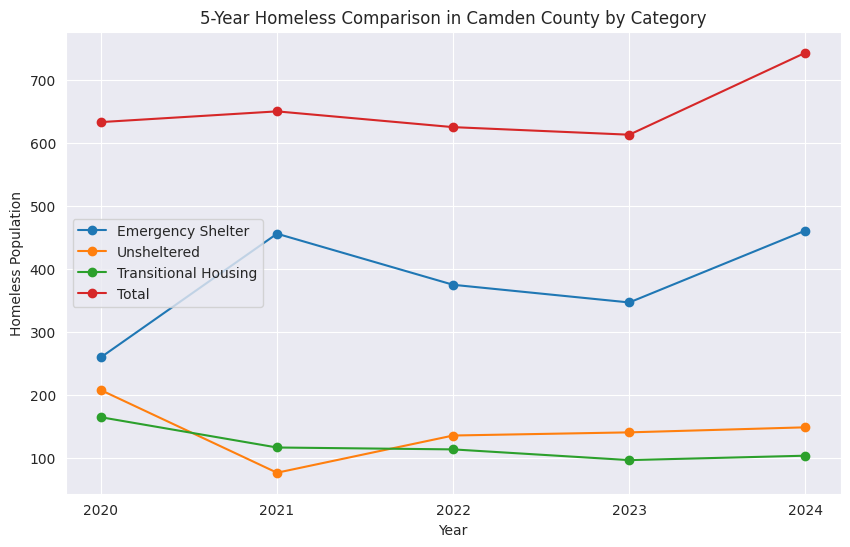

In [93]:

# Load the data from the raw Excel file
CountyFive = pd.read_excel('https://raw.githubusercontent.com/Funmiadebajo/GIS/main/5%20year%20homeless%20comparison.xlsx', engine='openpyxl')

# Strip whitespace from the column names
CountyFive.columns = CountyFive.columns.str.strip()

# Convert the 'Year' column to integers
CountyFive['Year'] = CountyFive['Year'].astype(int)

# Check the cleaned column names
print(CountyFive.columns)

# Set the figure size for the plot
plt.figure(figsize=(10, 6))

# Plot each category against the Year
plt.plot(CountyFive['Year'], CountyFive['Emergency Shelter'], marker='o', label='Emergency Shelter')
plt.plot(CountyFive['Year'], CountyFive['Unsheltered'], marker='o', label='Unsheltered')
plt.plot(CountyFive['Year'], CountyFive['Transitional Housing'], marker='o', label='Transitional Housing')
plt.plot(CountyFive['Year'], CountyFive['Total'], marker='o', label='Total')

# Set titles and labels
plt.title('5-Year Homeless Comparison in Camden County by Category')
plt.xlabel('Year')
plt.ylabel('Homeless Population')
plt.xticks(CountyFive['Year'])  # Set x-ticks to be the year values
plt.legend()
plt.grid(True)

# Show the plot
plt.show();


# Relationship Between Median Gross Rent and Homelssness in Camden County

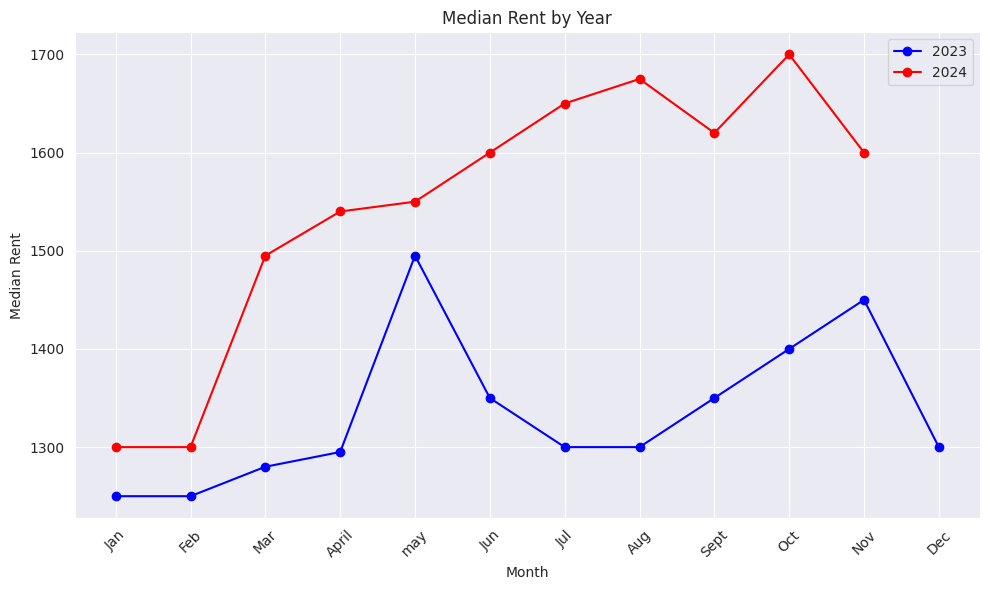

In [94]:

# Load the data from the provided URL
data = pd.read_excel('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/median%20rental%20by%20year.xlsx')

# Plot a line graph
plt.figure(figsize=(10, 6))

# Plotting '2023' and '2024' median rent values against 'Month' (use integer column names)
plt.plot(data['Month'], data[2023], marker='o', linestyle='-', color='b', label='2023')
plt.plot(data['Month'], data[2024], marker='o', linestyle='-', color='r', label='2024')

# Adding labels and title
plt.title('Median Rent by Year')
plt.xlabel('Month')
plt.ylabel('Median Rent')
plt.legend()

# Show the plot
plt.grid(True)
plt.xticks(rotation=45)  # Rotate the month labels for better readability
plt.tight_layout()
plt.show();


# Homelessness In Camden City, Camden NJ

Camden City is the critical intersection where high population, poverty, and homelessness converge. This indicates systemic socio-economic challenges in the area, where poverty significantly contributes to homelessness.

In my regression experiment, The Living in Poverty variable (coefficient: 0.1617, p-value: 0.728) shows a positive relationship with homelessness rates, suggesting that higher poverty rates are associated with increased homelessness. Although this relationship is not statistically significant at conventional levels, it aligns with existing literature on the connection between poverty and homelessness (Byrne et al., 2013). The lack of statistical significance may be due to the complex nature of homelessness, where poverty interacts with other factors to influence housing instability.
The White Alone variable demonstrates a statistically significant negative relationship with homelessness rates (coefficient: -0.5853, p-value: 0.016). This finding suggests that areas with higher percentages of White Alone population tend to have lower homelessness rates, which may reflect broader socioeconomic disparities and systemic inequalities (Olivet et al., 2021).
While the model indicates that educational attainment and racial composition have more statistically significant associations with homelessness rates than poverty levels, it's crucial to interpret these results cautiously. The relationship between poverty and homelessness is well-established in broader research (Shinn & Khadduri, 2020), and the lack of statistical significance in this particular model does not negate this connection. Instead, it highlights the need for more comprehensive analysis that considers the interplay between various socioeconomic factors and homelessness.

From the maps above, high population densities are observed in municipalities such as Camden City, Pennsauken Township, and Cherry Hill Township. These areas are urban centers or suburban regions with significant residential activity. However, the highest percentages of poverty are concentrated in Camden City, Pennsauken Township, and Merchantville Borough. This indicates a strong relationship between areas with high poverty rates and high population densities, particularly in Camden City.

Homelessness is heavily concentrated in Camden City, which aligns with its high poverty levels. This suggests that homelessness is not just linked to population density but is strongly driven by economic challenges, such as poverty.


In [95]:
njMun.head(10)

,Fid,Cousubns,Geoid,Namelsad,Classfp,Funcstat,Aland,Awater,Intptlat,Intptlon,Shape_Leng,Geocode,Globalid,Shape__Are,Shape__Len,Geometry
0,1,00885144,3400702200,Audubon borough,C5,F,3838781,35535,+39.8901277,-75.0723825,9407.757950,3400702200,81d661c6-35a7-42ed-8afd-5f35d0b0e807,3.871214e+06,9407.757866,"POLYGON ((495599.23 4415536.249, 495508.749 44..."
1,2,00885145,3400702230,Audubon Park borough,C5,F,389606,46935,+39.8968373,-75.0888190,2734.677596,3400702230,f8ccbea8-76dd-44e7-992b-e367d22e31a1,4.361934e+05,2734.677499,"POLYGON ((492866.221 4416337.872, 492855.687 4..."
2,3,00885149,3400703250,Barrington borough,C5,F,4095340,0,+39.8689349,-75.0513618,11456.984021,3400703250,9e9086b1-16e4-429f-b5c4-d967de1dbd82,4.092067e+06,11456.984073,"POLYGON ((496819.374 4414558.505, 496827.878 4..."
3,4,00885154,3400704750,Bellmawr borough,C5,F,7729295,315734,+39.8663560,-75.0946695,18085.471872,3400704750,bdd07346-3ee8-471e-befd-b8b9e16eb0a9,8.038608e+06,18085.472003,"POLYGON ((492951.896 4413667.751, 492968.147 4..."
4,5,00885158,3400705440,Berlin borough,C5,F,9307767,35573,+39.7920594,-74.9369855,14823.777678,3400705440,032f4608-e579-4343-a5e1-7d3778ce56c5,9.335884e+06,14823.777540,"POLYGON ((507881.319 4403761.193, 507873.371 4..."
5,6,00882152,3400705470,Berlin township,T1,A,8656740,15360,+39.8071159,-74.9241780,15771.555136,3400705470,e17a4101-16d7-4093-b9da-43f1044ceef7,8.665170e+06,15771.555122,"POLYGON ((507848.567 4406644.366, 507978.687 4..."
6,7,00885172,3400708170,Brooklawn borough,C5,F,1265110,105763,+39.8793503,-75.1203958,5697.800517,3400708170,1e1a2ee3-3807-458d-8af0-7a2d5df7de30,1.369780e+06,5697.800436,"POLYGON ((490740.818 4414218.502, 490736.285 4..."
7,8,00885177,3400710000,Camden city,C5,F,23106182,3676392,+39.9367868,-75.1066438,28004.054276,3400710000,f5c8c982-1593-4592-a38a-485a23bd7d98,2.676122e+07,28004.054367,"POLYGON ((493032.266 4419551.728, 492897.768 4..."
8,9,00882155,3400712280,Cherry Hill township,T1,A,62346260,321495,+39.9046107,-74.9969997,42634.513569,3400712280,561f8439-f9d9-47af-a877-f4c81e30fd7a,6.261764e+07,42634.513259,"POLYGON ((506224.674 4413748.279, 506174.32 44..."
9,10,00885183,3400712550,Chesilhurst borough,C5,F,4442825,4000,+39.7297952,-74.8805311,9002.409548,3400712550,db06a511-84e0-41f6-a5d9-e8afa47e852f,4.443282e+06,9002.409554,"POLYGON ((512006.451 4397643.342, 512016.246 4..."


In [96]:
# Load and clean the New Jersey municipalities shapefile
njMun = gpd.read_file('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Municipality.zip')
njMun.rename(columns={'NAMELSAD': 'Municipality'}, inplace=True)
# List of municipalities to keep unchanged
keep_unchanged = ["Berlin borough", "Berlin township", "Gloucester City", "Gloucester township"]

# Function to clean municipality names
def clean_municipality(name):
    name = name.strip()
    if name in keep_unchanged:
        return name
    if name == "Gloucester City city":
        return "Gloucester City"
    return ' '.join(word for word in name.split() if word.lower() not in ['borough', 'township'])

# Apply the cleaning function
njMun['Municipality'] = njMun['Municipality'].apply(clean_municipality)
njMun['Municipality'] = njMun['Municipality'].str.title()
print(njMun['Municipality'])

0                 Audubon
1            Audubon Park
2              Barrington
3                Bellmawr
4          Berlin Borough
5         Berlin Township
6               Brooklawn
7             Camden City
8             Cherry Hill
9             Chesilhurst
10              Clementon
11           Collingswood
12              Gibbsboro
13    Gloucester Township
14        Gloucester City
15                 Haddon
16            Haddonfield
17         Haddon Heights
18               Hi-Nella
19         Laurel Springs
20               Lawnside
21             Lindenwold
22               Magnolia
23          Merchantville
24          Mount Ephraim
25                 Oaklyn
26             Pennsauken
27              Pine Hill
28              Runnemede
29              Somerdale
30              Stratford
31              Tavistock
32               Voorhees
33              Waterford
34                Winslow
35              Woodlynne
Name: Municipality, dtype: object


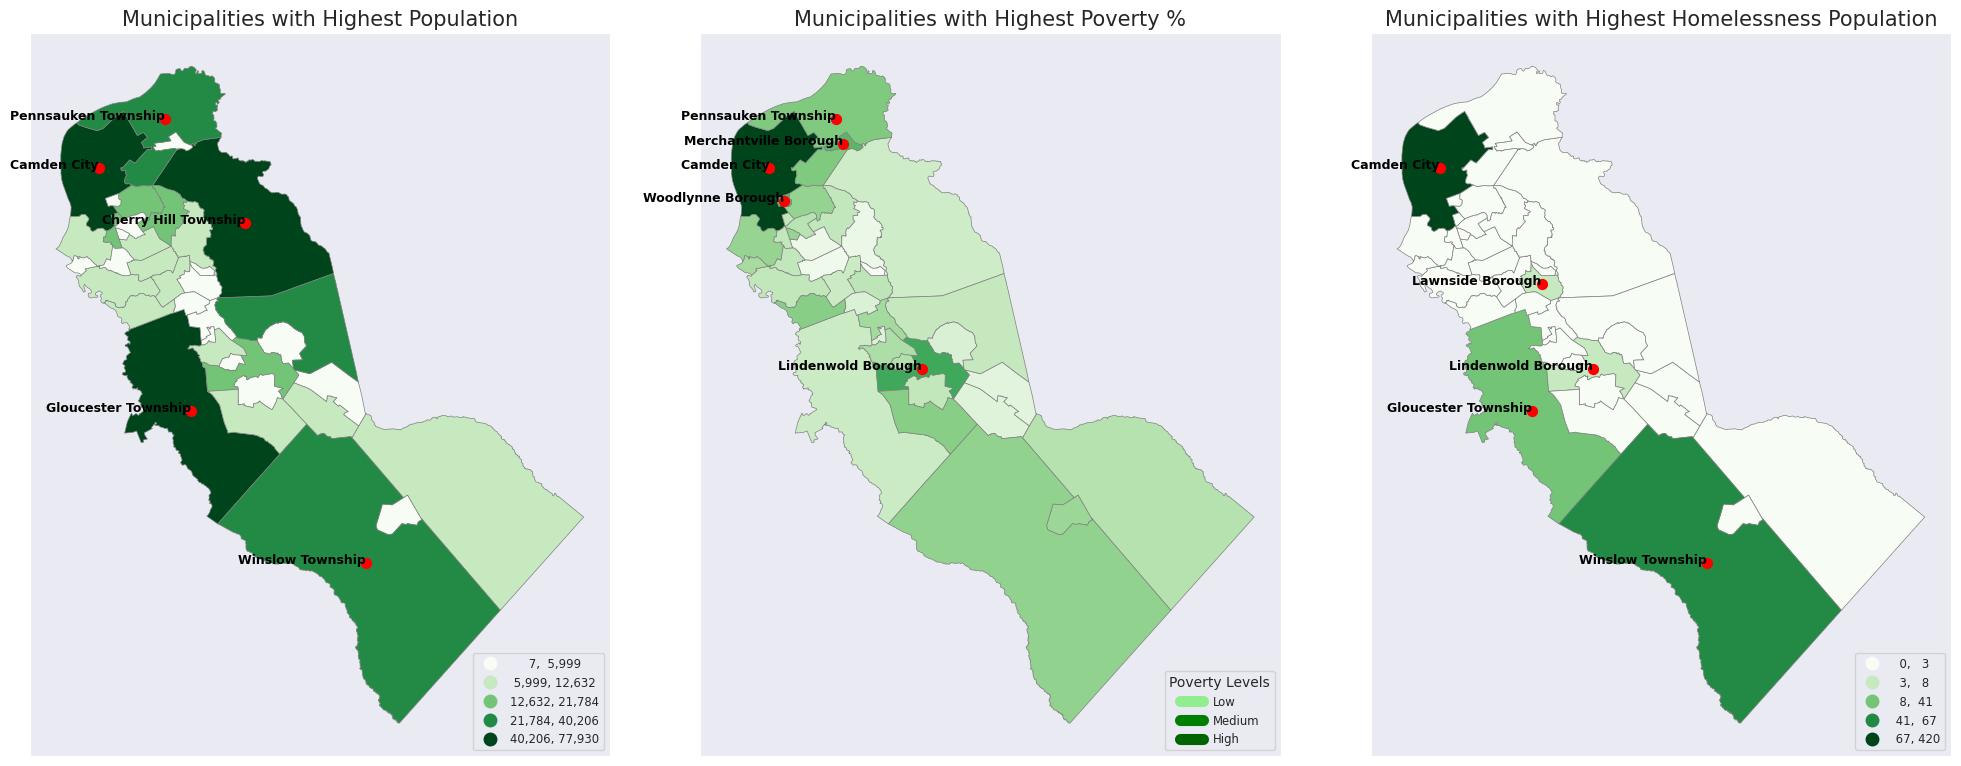

In [97]:
# Load and clean the New Jersey municipalities shapefile
njMun = gpd.read_file('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Municipality.zip')
njMun.rename(columns={'NAMELSAD': 'Municipality'}, inplace=True)
njMun['Municipality'] = njMun['Municipality'].str.strip().str.lower()

# Load datasets and merge with outer join
njMun_pop = load_and_merge('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/municipality%20population.xlsx')
njMun_pov = load_and_merge('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Municipality%20poverty.xlsx')
njMun_hom = load_and_merge('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/municipality%20homelessness.xlsx')

# Adjust bins for Poverty with three categories
poverty_bins = [0, 1, 5, 10]  # Define 3 bins: Low, Medium, High
poverty_labels = ["Low", "Medium", "High"]
njMun_pov['Poverty_bins'] = pd.cut(njMun_pov['Poverty'], bins=poverty_bins, labels=poverty_labels, include_lowest=True)

# Create subplots for the three maps
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Plot Population Data (first map)
njMun_pop.plot(
    ax=axs[0], column='population', legend=True, cmap='Greens', scheme='natural_breaks', k=5,
    edgecolor='grey', linewidth=0.5,
    legend_kwds={"fmt": "{:,.0f}", 'loc': 'lower right', 'title_fontsize': 'medium', 'fontsize': 'small'}
)
axs[0].set_title("Municipalities with Highest Population", fontsize=15)
axs[0].set_xticks([])
axs[0].set_yticks([])

# Label top 5 municipalities for Population
top_pop_municipalities = njMun_pop.nlargest(5, 'population')
for _, row in top_pop_municipalities.iterrows():
    axs[0].scatter(row.geometry.centroid.x, row.geometry.centroid.y, color='red', s=50, zorder=5)
    axs[0].text(row.geometry.centroid.x, row.geometry.centroid.y, row['Municipality'].title(),
                fontsize=9, ha='right', color='black', weight='bold', zorder=10)

# Plot Poverty Data (second map)
njMun_pov.plot(
    ax=axs[1], column='Poverty', legend=False, cmap='Greens', edgecolor='grey', linewidth=0.5
)
axs[1].set_title("Municipalities with Highest Poverty %", fontsize=15)
axs[1].set_xticks([])
axs[1].set_yticks([])

# Add separate legend for Poverty bins
handles = [plt.Line2D([0], [0], color='lightgreen', lw=8, label="Low"),
           plt.Line2D([0], [0], color='green', lw=8, label="Medium"),
           plt.Line2D([0], [0], color='darkgreen', lw=8, label="High")]
axs[1].legend(handles=handles, title="Poverty Levels", loc='lower right', fontsize='small', title_fontsize='medium')

# Label top 5 municipalities for Poverty
top_poverty_municipalities = njMun_pov.nlargest(5, 'Poverty')
for _, row in top_poverty_municipalities.iterrows():
    axs[1].scatter(row.geometry.centroid.x, row.geometry.centroid.y, color='red', s=50, zorder=5)
    axs[1].text(row.geometry.centroid.x, row.geometry.centroid.y, row['Municipality'].title(),
                fontsize=9, ha='right', color='black', weight='bold', zorder=10)

# Plot Homelessness Data (third map)
njMun_hom.plot(
    ax=axs[2], column='Homelessness', legend=True, cmap='Greens', scheme='natural_breaks', k=5,
    edgecolor='grey', linewidth=0.5,
    legend_kwds={"fmt": "{:,.0f}", 'loc': 'lower right', 'title_fontsize': 'medium', 'fontsize': 'small'}
)
axs[2].set_title("Municipalities with Highest Homelessness Population", fontsize=15)
axs[2].set_xticks([])
axs[2].set_yticks([])

# Label top 5 municipalities for Homelessness
top_homelessness_municipalities = njMun_hom.nlargest(5, 'Homelessness')
for _, row in top_homelessness_municipalities.iterrows():
    axs[2].scatter(row.geometry.centroid.x, row.geometry.centroid.y, color='red', s=50, zorder=5)
    axs[2].text(row.geometry.centroid.x, row.geometry.centroid.y, row['Municipality'].title(),
                fontsize=9, ha='right', color='black', weight='bold', zorder=10)

# Display the plot
plt.tight_layout()
plt.show();


# Homelessness as a function of income and housing Availability

This histogram portrays a diverse economic landscape within the county. The wide range of the histogram spanning from 180,000 DOllars highlights the income disparity within the county. The right skewed distribution signifies that most median household income are clustered around the lower end of the spectrum. The outliers are the few municipalities with median incomes exceeding 160,000 Doll. The peak of the histogram which falls between 60,000 and 80,000 indicates the most common median incomes across the county.

These numbers are vaulable for understanding the rental situation in correlation to homelss statistics.







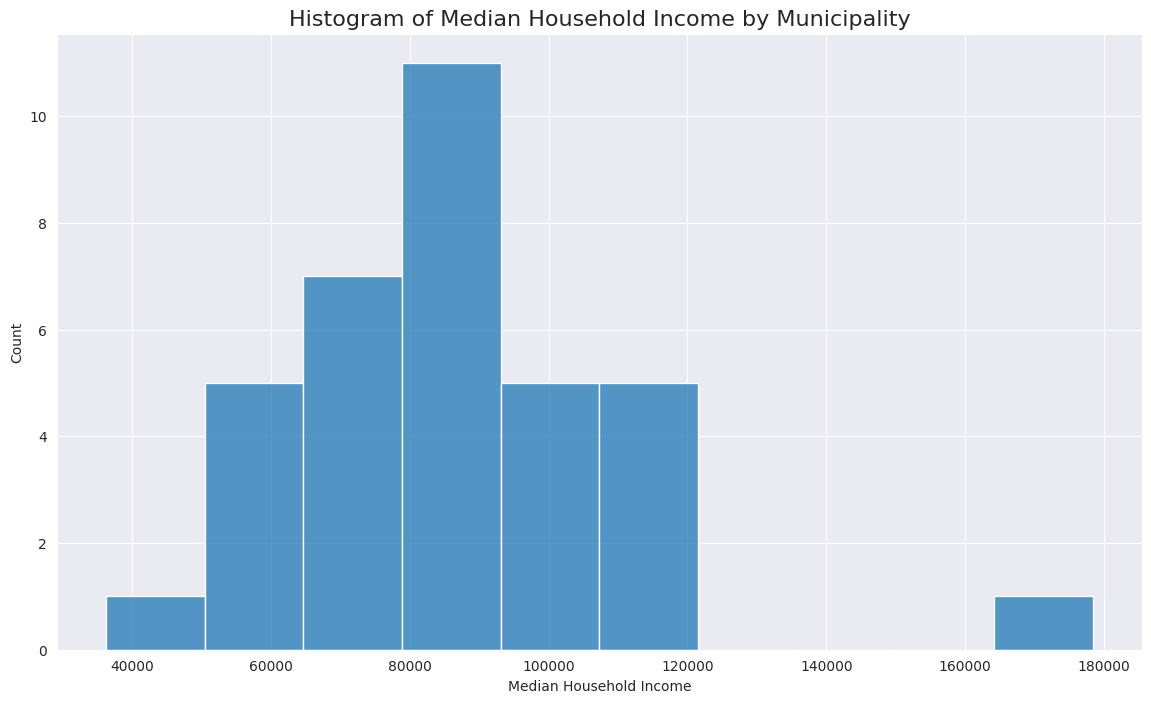

In [98]:
research_data = pd.read_csv('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/research_data.csv')
median_household_income = research_data['Median Household Income'].dropna()
plt.figure(figsize = (14, 8))
plt.title('Histogram of Median Household Income by Municipality', fontsize=16)
sns.histplot(median_household_income)
sns.set_style("darkgrid");

In [115]:
research_data = gpd.read_file('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/research_data.csv')
research_data = research_data.rename(columns={'Municipality': 'ignore', 'Statistics': 'Municipality'})
#print(research_data.columns)
research_data.head(20)

,Municipality,Total Population,Total PIT Count,Homelessness per 10000,Unsheltered,White Alone,Black Alone,Asian Alone,High School Graduate,Bachelors Degree,...,Moved From Abroad,Vacant Units,Actual Renters,30 Percent Income As Rent,Mon Housing Cost,Median Gross Rent,2-Person Household,4-Person Household,7-or-More Person Household,ignore
0,Audubon,8695.0,3.0,3.450258769,0.0,93.9,2.4,0.2,27.2,27.6,...,0.0,4.8,9.9,20.0,42.7,1183.0,33.1,17.4,1.0,AUDUBON PARK BORO
1,Audubon Park,1031.0,0.0,0.0,0.0,93.2,1.3,0.0,54.8,11.9,...,0.0,3.4,1.0,15.6,20.7,941.0,22.7,9.0,0.0,AUDUBON PARK BORO
2,Barrington,7022.0,0.0,0.0,0.0,90.0,1.2,3.3,27.0,27.6,...,0.0,2.1,3.8,24.4,52.1,1247.0,36.5,6.7,0.0,BARRINGTON BORO
3,Bellmawr,11677.0,3.0,2.569153036,0.0,75.3,5.1,9.7,39.4,15.8,...,0.1,6.2,0.3,24.4,43.7,1081.0,25.6,12.3,1.5,BELLMAWR BORO
4,Berlin Borough,7489.0,0.0,0.0,0.0,77.0,12.5,0.7,27.7,26.1,...,0.0,5.7,4.4,4.6,40.8,1616.0,33.2,14.3,1.0,BERLIN BORO
5,Berlin Township,5881.0,0.0,0.0,0.7,68.1,5.3,6.9,37.2,19.8,...,0.0,4.2,4.0,48.7,60.5,1339.0,22.5,3.9,1.0,BERLIN BORO
6,Brooklawn,1894.0,2.0,10.55966209,0.0,77.5,11.3,6.8,39.1,10.8,...,0.0,11.3,9.2,14.9,37.5,1443.0,25.4,6.9,2.1,BROOKLAWN BORO
7,Camden City,71799.0,420.0,58.49663644,84.4,9.9,42.9,2.1,35.1,5.8,...,1.4,12.6,4.9,24.8,39.6,1091.0,24.4,14.3,3.0,CAMDEN CITY
8,Cherry Hill,74934.0,2.0,0.26690154,1.4,71.1,6.6,13.5,18.8,29.4,...,0.7,5.1,9.6,25.7,24.1,1726.0,33.8,15.8,0.9,CHERRY HILL TWP
9,Chesilhurst,1384.0,0.0,0.0,0.0,47.0,40.5,0.0,32.8,13.4,...,0.0,12.3,11.9,27.7,16.9,996.0,31.6,10.1,1.6,CHESILHURST BORO


**Load and Clean Data from Excel**

In [122]:
# Load and clean the New Jersey municipalities shapefile
njMun = gpd.read_file('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Municipality.zip')
njMun.rename(columns={'NAMELSAD': 'Municipality'}, inplace=True)
# List of municipalities to keep unchanged
keep_unchanged = ["Berlin borough", "Berlin township", "Gloucester City", "Gloucester township"]

# Function to clean municipality names
def clean_municipality(name):
    name = name.strip()
    if name in keep_unchanged:
        return name
    if name == "Gloucester City city":
        return "Gloucester City"
    return ' '.join(word for word in name.split() if word.lower() not in ['borough', 'township'])

# Apply the cleaning function
njMun['Municipality'] = njMun['Municipality'].apply(clean_municipality)
njMun['Municipality'] = njMun['Municipality'].str.title()
njMun.head(20)

,FID,COUSUBNS,GEOID,Municipality,CLASSFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,GEOCODE,GlobalID,Shape__Are,Shape__Len,geometry
0,1,00885144,3400702200,Audubon,C5,F,3838781,35535,+39.8901277,-75.0723825,9407.757950,3400702200,81d661c6-35a7-42ed-8afd-5f35d0b0e807,3.871214e+06,9407.757866,"POLYGON ((495599.23 4415536.249, 495508.749 44..."
1,2,00885145,3400702230,Audubon Park,C5,F,389606,46935,+39.8968373,-75.0888190,2734.677596,3400702230,f8ccbea8-76dd-44e7-992b-e367d22e31a1,4.361934e+05,2734.677499,"POLYGON ((492866.221 4416337.872, 492855.687 4..."
2,3,00885149,3400703250,Barrington,C5,F,4095340,0,+39.8689349,-75.0513618,11456.984021,3400703250,9e9086b1-16e4-429f-b5c4-d967de1dbd82,4.092067e+06,11456.984073,"POLYGON ((496819.374 4414558.505, 496827.878 4..."
3,4,00885154,3400704750,Bellmawr,C5,F,7729295,315734,+39.8663560,-75.0946695,18085.471872,3400704750,bdd07346-3ee8-471e-befd-b8b9e16eb0a9,8.038608e+06,18085.472003,"POLYGON ((492951.896 4413667.751, 492968.147 4..."
4,5,00885158,3400705440,Berlin Borough,C5,F,9307767,35573,+39.7920594,-74.9369855,14823.777678,3400705440,032f4608-e579-4343-a5e1-7d3778ce56c5,9.335884e+06,14823.777540,"POLYGON ((507881.319 4403761.193, 507873.371 4..."
5,6,00882152,3400705470,Berlin Township,T1,A,8656740,15360,+39.8071159,-74.9241780,15771.555136,3400705470,e17a4101-16d7-4093-b9da-43f1044ceef7,8.665170e+06,15771.555122,"POLYGON ((507848.567 4406644.366, 507978.687 4..."
6,7,00885172,3400708170,Brooklawn,C5,F,1265110,105763,+39.8793503,-75.1203958,5697.800517,3400708170,1e1a2ee3-3807-458d-8af0-7a2d5df7de30,1.369780e+06,5697.800436,"POLYGON ((490740.818 4414218.502, 490736.285 4..."
7,8,00885177,3400710000,Camden City,C5,F,23106182,3676392,+39.9367868,-75.1066438,28004.054276,3400710000,f5c8c982-1593-4592-a38a-485a23bd7d98,2.676122e+07,28004.054367,"POLYGON ((493032.266 4419551.728, 492897.768 4..."
8,9,00882155,3400712280,Cherry Hill,T1,A,62346260,321495,+39.9046107,-74.9969997,42634.513569,3400712280,561f8439-f9d9-47af-a877-f4c81e30fd7a,6.261764e+07,42634.513259,"POLYGON ((506224.674 4413748.279, 506174.32 44..."
9,10,00885183,3400712550,Chesilhurst,C5,F,4442825,4000,+39.7297952,-74.8805311,9002.409548,3400712550,db06a511-84e0-41f6-a5d9-e8afa47e852f,4.443282e+06,9002.409554,"POLYGON ((512006.451 4397643.342, 512016.246 4..."


In [137]:
# Merge datasets on 'Municipality' with an outer join and indicator
merged_data = njMun.merge(research_data, on='Municipality', how='outer', indicator=True)

import pandas as pd
import geopandas as gpd
from shapely.validation import make_valid

# Step 1: Remove duplicate rows
merged_data = merged_data.drop_duplicates()

# Step 2: Handle missing values
# Drop rows where critical columns are missing (e.g., geometry or key attributes)
critical_columns = ['geometry', 'Median Household Income', 'Vacant Units', 'Actual Renters']
merged_data = merged_data.dropna(subset=critical_columns, how='any')

# Step 3: Convert numeric columns to proper dtype
numeric_columns = ['Median Household Income', 'Vacant Units', 'Actual Renters']
for col in numeric_columns:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# Step 4: Drop rows with missing or invalid geometries
merged_data = merged_data[merged_data['geometry'].notnull()]

# Step 5: Ensure all geometries are valid
merged_data['geometry'] = merged_data['geometry'].apply(make_valid)

# Step 6: Reindex the GeoDataFrame to clean row indices
merged_data = merged_data.reset_index(drop=True)

# Step 7: (Optional) Compute centroids for easier plotting/labeling later
merged_data['centroid'] = merged_data['geometry'].centroid

# Step 8: Verify the cleaned data
print(merged_data.info())  # Ensure no missing critical data
print(merged_data.head())  # Preview the cleaned data


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   FID                          4 non-null      float64 
 1   COUSUBNS                     4 non-null      object  
 2   GEOID                        4 non-null      object  
 3   Municipality                 4 non-null      object  
 4   CLASSFP                      4 non-null      object  
 5   FUNCSTAT                     4 non-null      object  
 6   ALAND                        4 non-null      float64 
 7   AWATER                       4 non-null      float64 
 8   INTPTLAT                     4 non-null      object  
 9   INTPTLON                     4 non-null      object  
 10  Shape_Leng                   4 non-null      float64 
 11  GEOCODE                      4 non-null      float64 
 12  GlobalID                     4 non-null      object  
 13  S

KeyError: 'FID'

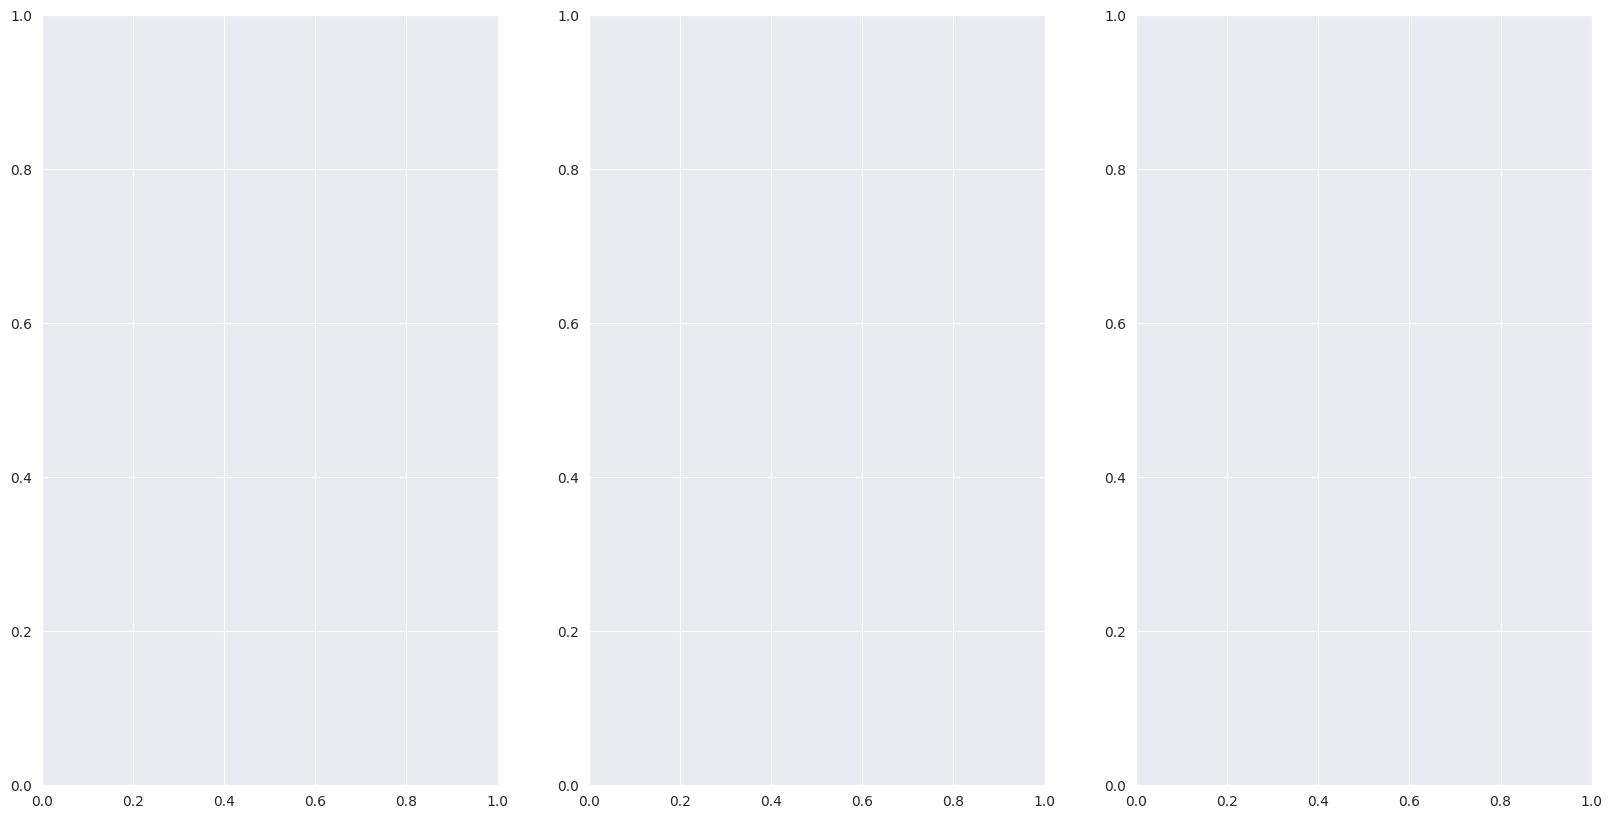

In [140]:
# Define color scheme
color_scheme = "Spectral"

# Create subplots for the three maps
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
titles = ["Municipalities with Median Gross Rent", "Vacancies", "Renters between 2020 and 2023"]

for i, (key, merged_df) in enumerate(merged_data.items()):
    column = datasets[key]  # Use the original column name
    ax = axs[i]

    if merged_df[column].nunique() > 1:
        # For low-value columns, use quantile-based bins for better differentiation
        if column in ['Vacancies', 'Actual Renters']:
            try:
                merged_df['Custom Bins'] = pd.qcut(
                    merged_df[column],
                    q=5,
                    labels=["Very Low", "Low", "Moderate", "High", "Very High"],
                    duplicates="drop"
                )
            except ValueError:
                # Fallback to using NaturalBreaks if too few distinct values remain
                merged_df['Custom Bins'] = pd.cut(
                    merged_df[column],
                    bins=5,
                    labels=["Very Low", "Low", "Moderate", "High", "Very High"],
                    include_lowest=True
                )

            merged_df.plot(
                ax=ax,
                column='Custom Bins',
                legend=True,
                cmap=color_scheme,
                edgecolor='grey',
                linewidth=0.5,
                legend_kwds={'title': column, 'loc': 'lower right'}
            )
        else:
            merged_df.plot(
                ax=ax,
                column=column,
                legend=True,
                cmap=color_scheme,
                scheme='NaturalBreaks',
                k=5,
                edgecolor='grey',
                linewidth=0.5,
                legend_kwds={"fmt": "{:,.0f}", "loc": "lower right"}
            )

        # Annotate top 5 municipalities by name
        top_5 = merged_df.nlargest(5, column)

        for _, row in top_5.iterrows():  # Corrected indentation
            ax.text(
                row.geometry.centroid.x,
                row.geometry.centroid.y,
                f"{row['Municipality'].title()}",
                fontsize=8, ha='center', color='black'
            )

    ax.set_title(titles[i], fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


TypeError: can't multiply sequence by non-int of type 'float'

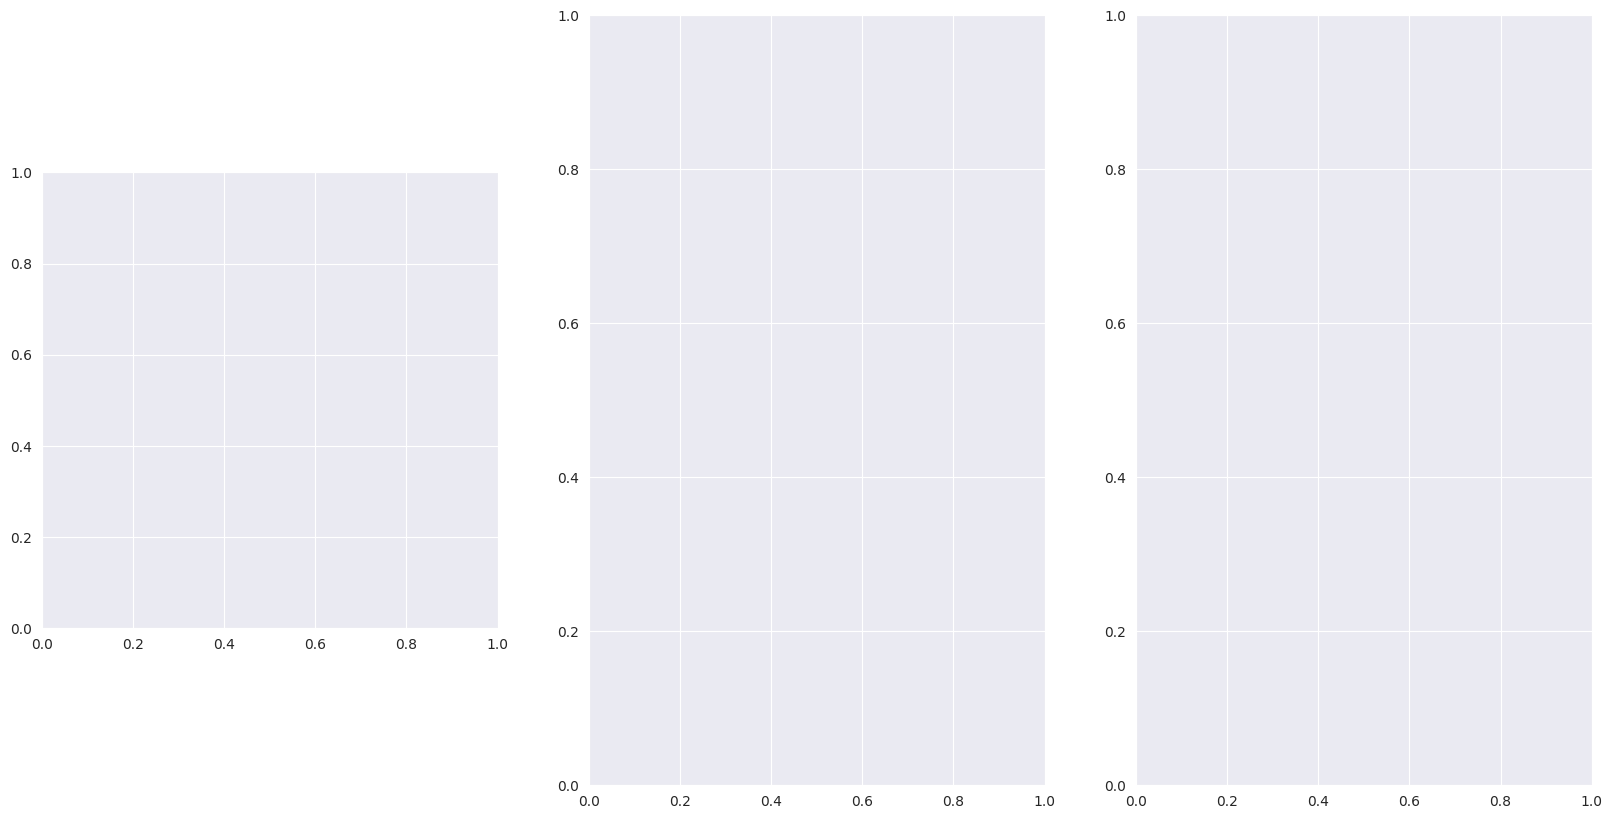

In [130]:
# Create subplots for the three maps
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Plot Median Household Income Data
merged_data.plot(ax=axs[0], column='Median Household Income', legend=True, cmap='Greens', scheme='natural_breaks', k=5,
                     edgecolor='grey', linewidth=0.5, legend_kwds={"fmt": "{:,.0f}",
                     'loc': 'lower right', 'title_fontsize': 'medium', 'fontsize': 'small', 'markerscale': 1.4})
axs[0].set_title("Municipalities in Camden with Highest Median Household Income", fontsize=15)
cx.add_basemap(axs[0], source=cx.providers.CartoDB.Positron)
axs[0].set_xticks([])  # Remove x-axis ticks
axs[0].set_yticks([])  # Remove y-axis ticks

# Label the top 5 municipalities for High Median Household Income
top_pop_municipalities = merged_data.nlargest(5, 'Median Household Income')
for idx, row in top_pop_municipalities.iterrows():
    axs[0].scatter(row.geometry.centroid.x, row.geometry.centroid.y, color='red', s=50, zorder=5)  # Pin marker
    axs[0].text(row.geometry.centroid.x, row.geometry.centroid.y, row['MUN'].title(),
                fontsize=9, ha='right', color='black', weight='bold', zorder=10)  # Label

# Plot Vacant Units Data
merged_data.plot(ax=axs[1], column='Vacant Units', legend=True, cmap='Greens', scheme='NaturalBreaks', k=5,
                     edgecolor='grey', linewidth=2, legend_kwds={"fmt": "{:,.0f}",
                     'loc': 'lower right', 'title_fontsize': 'medium', 'fontsize': 'small', 'markerscale': 1.4})
axs[1].set_title("Vacant Units ", fontsize=15)
cx.add_basemap(axs[1], source=cx.providers.CartoDB.Positron)
axs[1].set_xticks([])  # Remove x-axis ticks
axs[1].set_yticks([])  # Remove y-axis ticks

# Label the top 5 municipalities with Vacant Units
Vacant_Units = merged_data.nlargest(5, 'Vacant Units')
for idx, row in Vacant_Units.iterrows():
    axs[1].scatter(row.geometry.centroid.x, row.geometry.centroid.y, color='red', s=50, zorder=5)  # Pin marker
    axs[1].text(row.geometry.centroid.x, row.geometry.centroid.y, row['MUN'].title(),
                fontsize=9, ha='right', color='black', weight='bold', zorder=10)  # Label

# Plot Actual Renters Data
merged_data.plot(ax=axs[2], column='Actual Renters', legend=False, cmap='Greens', scheme='natural_breaks', k=5,
                     edgecolor='grey', linewidth=0.5, legend_kwds={"fmt": "{:,.0f}",
                     'loc': 'lower right', 'title_fontsize': 'medium', 'fontsize': 'small', 'markerscale': 1.4})
axs[2].set_title("Actual Renters Between 2020 and 2023", fontsize=15)
cx.add_basemap(axs[2], source=cx.providers.CartoDB.Positron)
axs[2].set_xticks([])  # Remove x-axis ticks
axs[2].set_yticks([])  # Remove y-axis ticks

# Label the top 5 municipalities for Actual Renters
Actual_Renters = merged_data.nlargest(5, 'Actual Renters')
for idx, row in Actual_Renters.iterrows():
    axs[2].scatter(row.geometry.centroid.x, row.geometry.centroid.y, color='red', s=50, zorder=5)  # Pin marker
    axs[2].text(row.geometry.centroid.x, row.geometry.centroid.y, row['MUN'].title(),
                fontsize=9, ha='right', color='black', weight='bold', zorder=10)  # Label

# Display the plot
plt.tight_layout()
plt.show()




In [107]:

research_data = pd.read_csv('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/research_data.csv')
research_data = research_data.rename(columns={'Municipality': 'ignore', 'Statistics': 'Municipality'})
print(research_data.columns)

njMun = gpd.read_file('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Municipality.zip')

# Standardize the 'Municipality' column for merging
research_data['Municipality'] = research_data['Municipality'].str.strip().str.title()
njMun['Municipality'] = njMun['Municipality'].str.strip().str.title()

# Merge datasets on 'Municipality' with an outer join and indicator
merged_data = njMun.merge(research_data, on='Municipality', how='outer', indicator=True)

# Ensure the GeoDataFrame is in EPSG:3857 projection for compatibility with basemaps
merged_data = merged_data.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# Define a common color map
cmap = 'viridis'

# Plot Median Household Income
merged_data.plot(
    column='Median Household Income',
    cmap=cmap,
    linewidth=0.8,
    edgecolor='0.8',
    ax=ax[0],
    legend=True,
    legend_kwds={'label': "Median Household Income"}
)
ax[0].set_title('Median Household Income')
cx.add_basemap(ax[0], source=cx.providers.CartoDB.Positron)

# Plot Vacant Units
merged_data.plot(
    column='Vacant Units',
    cmap=cmap,
    linewidth=0.8,
    edgecolor='0.8',
    ax=ax[1],
    legend=True,
    legend_kwds={'label': "Vacant Units"}
)
ax[1].set_title('Vacant Units')
cx.add_basemap(ax[1], source=cx.providers.CartoDB.Positron)

# Plot Actual Renters
merged_data.plot(
    column='Actual Renters',
    cmap=cmap,
    linewidth=0.8,
    edgecolor='0.8',
    ax=ax[2],
    legend=True,
    legend_kwds={'label': "Actual Renters"}
)
ax[2].set_title('Actual Renters')
cx.add_basemap(ax[2], source=cx.providers.CartoDB.Positron)

# Formatting
for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Print merge indicator results to check unmatched entries
print("Merge Indicator Results:")
print(merged_data['_merge'].value_counts())

Index(['Municipality', 'Total Population', 'Total PIT Count',
       'Homelessness per 10000', 'Unsheltered ', 'White Alone', 'Black Alone',
       'Asian Alone', 'High School Graduate', 'Bachelors Degree', 'Unemployed',
       'Living In Poverty', 'Married Couple Family', 'Male Householder',
       'Female Householder', 'Single Parent Children',
       'Median Household Income', 'Moved Within Same County',
       'Moved From Different County', 'Moved From Different State',
       'Moved From Abroad', 'Vacant Units', 'Actual Renters',
       '30 Percent Income As Rent', 'Mon Housing Cost', 'Median Gross Rent',
       '2-Person Household', '4-Person Household',
       '7-or-More Person Household', 'ignore'],
      dtype='object')


KeyError: 'Municipality'

In [104]:
research_data.columns = research_data.columns.str.strip().str.title()
njMun.columns = njMun.columns.str.strip().str.title()
print(research_data.columns)
print(njMun.columns)

Index(['Statistics', 'Total Population', 'Total Pit Count',
       'Homelessness Per 10000', 'Unsheltered', 'White Alone', 'Black Alone',
       'Asian Alone', 'High School Graduate', 'Bachelors Degree', 'Unemployed',
       'Living In Poverty', 'Married Couple Family', 'Male Householder',
       'Female Householder', 'Single Parent Children',
       'Median Household Income', 'Moved Within Same County',
       'Moved From Different County', 'Moved From Different State',
       'Moved From Abroad', 'Vacant Units', 'Actual Renters',
       '30 Percent Income As Rent', 'Mon Housing Cost', 'Median Gross Rent',
       '2-Person Household', '4-Person Household',
       '7-Or-More Person Household', 'Municipality'],
      dtype='object')
Index(['Fid', 'Cousubns', 'Geoid', 'Namelsad', 'Classfp', 'Funcstat', 'Aland',
       'Awater', 'Intptlat', 'Intptlon', 'Shape_Leng', 'Geocode', 'Globalid',
       'Shape__Are', 'Shape__Len', 'Geometry'],
      dtype='object')


In [ ]:
# Load and clean datasets
datasets = {
    "Vacancies": "Vacancies",
    "Actual_Renters": "Actual Renters",
    "Median Gross Rent": "Median Gross Rent"
}

cleaned_data = {}
for col_name, sheet_col in datasets.items():
    df = pd.read_excel('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Median%20Income%202022.xlsx')
    df[sheet_col] = df[sheet_col].replace({'\$': '', ',': ''}, regex=True)
    df[sheet_col] = pd.to_numeric(df[sheet_col], errors='coerce')
    df = df.dropna(subset=[sheet_col])
    df['Municipality'] = df['Municipality'].str.strip().str.lower()
    cleaned_data[col_name] = df

# Merge data with njMun using outer merge
merged_data = {}
for key, df in cleaned_data.items():
    merged_data[key] = njMun.merge(df, on='Municipality', how='outer', indicator=f'{key}_merge')

# Define color scheme
color_scheme = "Spectral"

# Create subplots for the three maps
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
titles = ["Municipalities with Median Gross Rent", "Vacancies", "Renters between 2020 and 2023"]

for i, (key, merged_df) in enumerate(merged_data.items()):
    column = datasets[key]  # Use the original column name
    ax = axs[i]

    if merged_df[column].nunique() > 1:
        # For low-value columns, use quantile-based bins for better differentiation
        if column in ['Vacancies', 'Actual Renters']:
            try:
                merged_df['Custom Bins'] = pd.qcut(
                    merged_df[column],
                    q=5,
                    labels=["Very Low", "Low", "Moderate", "High", "Very High"],
                    duplicates="drop"
                )
            except ValueError:
                # Fallback to using NaturalBreaks if too few distinct values remain
                merged_df['Custom Bins'] = pd.cut(
                    merged_df[column],
                    bins=5,
                    labels=["Very Low", "Low", "Moderate", "High", "Very High"],
                    include_lowest=True
                )

            merged_df.plot(
                ax=ax,
                column='Custom Bins',
                legend=True,
                cmap=color_scheme,
                edgecolor='grey',
                linewidth=0.5,
                legend_kwds={'title': column, 'loc': 'lower right'}
            )
        else:
            merged_df.plot(
                ax=ax,
                column=column,
                legend=True,
                cmap=color_scheme,
                scheme='NaturalBreaks',
                k=5,
                edgecolor='grey',
                linewidth=0.5,
                legend_kwds={"fmt": "{:,.0f}", "loc": "lower right"}
            )

        # Annotate top 5 municipalities by name
        top_5 = merged_df.nlargest(5, column)
        for _, row in top_5.iterrows():
            ax.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{row['Municipality'].title()}",
                    fontsize=8, ha='center', color='black')

    ax.set_title(titles[i], fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show();


In [ ]:


# Load municipality data and clean names
njMun = gpd.read_file('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Municipality.zip')
njMun.rename(columns={'NAMELSAD': 'Municipality'}, inplace=True)

# Adjusted function to preserve specific municipalities while cleaning others
def clean_municipality_name(name):
    # Preserve the distinction for Berlin Borough and Township
    if 'berlin borough' in name or 'berlin township' in name:
        return name.lower().strip()
    # Clean other municipality names
    return re.sub(r'\s(borough|township|city|village|town)$', '', name, flags=re.IGNORECASE).strip().lower()

njMun['Municipality'] = njMun['Municipality'].apply(clean_municipality_name)

# Load and clean datasets
datasets = {
    "Vacancies": "Vacancies",
    "Actual_Renters": "Actual Renters",
    "Median Gross Rent": "Median Gross Rent"
}

cleaned_data = {}
for col_name, sheet_col in datasets.items():
    df = pd.read_excel('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Median%20Income%202022.xlsx')
    df[sheet_col] = df[sheet_col].replace({'\$': '', ',': ''}, regex=True)
    df[sheet_col] = pd.to_numeric(df[sheet_col], errors='coerce')
    df = df.dropna(subset=[sheet_col])
    df['Municipality'] = df['Municipality'].str.strip().str.lower()
    cleaned_data[col_name] = df

# Merge data with njMun using outer merge
merged_data = {}
for key, df in cleaned_data.items():
    merged_data[key] = njMun.merge(df, on='Municipality', how='outer', indicator=f'{key}_merge')

# Define color scheme
color_scheme = "Spectral"

# Create subplots for the three maps
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
titles = ["Municipalities with Median Gross Rent", "Vacancies", "Renters between 2020 and 2023"]

for i, (key, merged_df) in enumerate(merged_data.items()):
    column = datasets[key]  # Use the original column name
    ax = axs[i]

    if merged_df[column].nunique() > 1:
        # For low-value columns, use quantile-based bins for better differentiation
        if column in ['Vacancies', 'Actual Renters']:
            try:
                merged_df['Custom Bins'] = pd.qcut(
                    merged_df[column],
                    q=5,
                    labels=["Very Low", "Low", "Moderate", "High", "Very High"],
                    duplicates="drop"
                )
            except ValueError:
                # Fallback to using NaturalBreaks if too few distinct values remain
                merged_df['Custom Bins'] = pd.cut(
                    merged_df[column],
                    bins=5,
                    labels=["Very Low", "Low", "Moderate", "High", "Very High"],
                    include_lowest=True
                )

            merged_df.plot(
                ax=ax,
                column='Custom Bins',
                legend=True,
                cmap=color_scheme,
                edgecolor='grey',
                linewidth=0.5,
                legend_kwds={'title': column, 'loc': 'lower right'}
            )
        else:
            merged_df.plot(
                ax=ax,
                column=column,
                legend=True,
                cmap=color_scheme,
                scheme='NaturalBreaks',
                k=5,
                edgecolor='grey',
                linewidth=0.5,
                legend_kwds={"fmt": "{:,.0f}", "loc": "lower right"}
            )

        # Annotate top 5 municipalities by name
        top_5 = merged_df.nlargest(5, column)
        for _, row in top_5.iterrows():
            ax.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{row['Municipality'].title()}",
                    fontsize=8, ha='center', color='black')

    ax.set_title(titles[i], fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show();


plot rent burden homelessness and household income here

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re
from matplotlib.colors import ListedColormap

# Load municipality data and clean names
njMun = gpd.read_file('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Municipality.zip')
njMun.rename(columns={'NAMELSAD': 'Municipality'}, inplace=True)
njMun['Municipality'] = njMun['Municipality'].str.strip().str.lower()

def clean_municipality_name(name):
    return re.sub(r'\s(Borough|Township|City|Village|Town)$', '', name, flags=re.IGNORECASE).strip().lower()

njMun['Municipality'] = njMun['Municipality'].apply(clean_municipality_name)

# Load and clean Rent Burden data
Rent_Burden = pd.read_excel('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Median%20Income%202022.xlsx')
Rent_Burden['Rent Burden'] = pd.to_numeric(
    Rent_Burden['Rent Burden'].replace({'%': '', ',': ''}, regex=True), errors='coerce')
Rent_Burden['Municipality'] = Rent_Burden['Municipality'].str.strip().str.lower()

# Load and clean Median Household Income data
median_income = pd.read_excel('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Median%20Income%202022.xlsx')
median_income['Median Household Income'] = pd.to_numeric(
    median_income['Median Household Income'].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
median_income['Municipality'] = median_income['Municipality'].str.strip().str.lower()

# Merge the data with njMun using 'outer' join
rent_burden_map = njMun.merge(Rent_Burden, on='Municipality', how='outer', indicator=True)
income_map = njMun.merge(median_income, on='Municipality', how='outer', indicator=True)

# Bin Rent Burden into categories
rent_burden_map['Rent Burden Category'] = pd.qcut(
    rent_burden_map['Rent Burden'],
    q=5,
    labels=["Very Low", "Low", "Medium", "High", "Very High"],
    duplicates="drop"
)

# Define color scheme
color_scheme = "Spectral"

# Create subplots for the two maps
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plot Rent Burden
rent_burden_map.plot(
    ax=axs[0],
    column="Rent Burden Category",
    legend=True,
    cmap=color_scheme,
    edgecolor="grey",
    linewidth=0.5,
    legend_kwds={"title": "Rent Burden", "loc": "lower right"}
)
axs[0].set_title("Rent Burden (%)", fontsize=15)
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot Median Household Income
income_map.plot(
    ax=axs[1],
    column="Median Household Income",
    legend=True,
    cmap=color_scheme,
    scheme="NaturalBreaks",
    k=5,
    edgecolor="grey",
    linewidth=0.5,
    legend_kwds={"fmt": "{:,.0f}", "loc": "lower right"}
)
axs[1].set_title("Median Household Income ($)", fontsize=15)
axs[1].set_xticks([])
axs[1].set_yticks([])

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
# Load and clean Rent Burden data
Rent_Burden = pd.read_excel(
    'https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Median%20Income%202022.xlsx')
Rent_Burden['Rent Burden'] = Rent_Burden['Rent Burden'].replace({'%': '', ',': ''}, regex=True)
Rent_Burden['Rent Burden'] = pd.to_numeric(Rent_Burden['Rent Burden'], errors='coerce')
Rent_Burden = Rent_Burden.dropna(subset=['Rent Burden'])

# Load and clean Median Household Income data
median_income = pd.read_excel(
    'https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Median%20Income%202022.xlsx'
)
median_income['Median Household Income'] = median_income['Median Household Income'].replace({'\$': '', ',': ''}, regex=True)
median_income['Median Household Income'] = pd.to_numeric(median_income['Median Household Income'], errors='coerce')
median_income = median_income.dropna(subset=['Median Household Income'])

# Load homelessness data
homelessness_data = pd.read_excel(
    'https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/municipality%20homelessness.xlsx'
)
homelessness_data = clean_municipality_names(homelessness_data, 'Municipality')

# Normalize Municipality names in Rent_Burden, MedGroRen, and median_income if necessary
Rent_Burden['Municipality'] = Rent_Burden['Municipality'].str.strip().str.lower()
median_income['Municipality'] = median_income['Municipality'].str.strip().str.lower()

# Merge the data with njMun using 'outer' join and include indicator
njMun4 = njMun.merge(Rent_Burden, on='Municipality', how='outer', indicator='rent_burden_merge')
njMun5 = njMun.merge(MedGroRen, on='Municipality', how='outer', indicator='median_rent_merge')
njMun6 = njMun.merge(median_income, on='Municipality', how='outer', indicator='median_income_merge')
njMun7 = njMun.merge(homelessness_data, on='Municipality', how='outer', indicator='homelessness_merge')

# Load and clean datasets
datasets = {
    "Vacancies": "Vacancies",
    "Actual_Renters": "Actual Renters",
    "Median Gross Rent": "Median Gross Rent"
}

cleaned_data = {}
for col_name, sheet_col in datasets.items():
    df = pd.read_excel('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Median%20Income%202022.xlsx')
    df[sheet_col] = df[sheet_col].replace({'\$': '', ',': ''}, regex=True)
    df[sheet_col] = pd.to_numeric(df[sheet_col], errors='coerce')
    df = df.dropna(subset=[sheet_col])
    df['Municipality'] = df['Municipality'].str.strip().str.lower()
    cleaned_data[col_name] = df

# Merge data with njMun using outer merge
merged_data = {}
for key, df in cleaned_data.items():
    merged_data[key] = njMun.merge(df, on='Municipality', how='outer', indicator=f'{key}_merge')

# Define color scheme
color_scheme = "Spectral"

# Create subplots for the three maps
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
titles = ["Municipalities with Median Gross Rent", "Vacancies", "Renters between 2020 and 2023"]

for i, (key, merged_df) in enumerate(merged_data.items()):
    column = datasets[key]  # Use the original column name
    ax = axs[i]

    if merged_df[column].nunique() > 1:
        # For low-value columns, use quantile-based bins for better differentiation
        if column in ['Vacancies', 'Actual Renters']:
            try:
                merged_df['Custom Bins'] = pd.qcut(
                    merged_df[column],
                    q=5,
                    labels=["Very Low", "Low", "Moderate", "High", "Very High"],
                    duplicates="drop"
                )
            except ValueError:
                # Fallback to using NaturalBreaks if too few distinct values remain
                merged_df['Custom Bins'] = pd.cut(
                    merged_df[column],
                    bins=5,
                    labels=["Very Low", "Low", "Moderate", "High", "Very High"],
                    include_lowest=True
                )

            merged_df.plot(
                ax=ax,
                column='Custom Bins',
                legend=True,
                cmap=color_scheme,
                edgecolor='grey',
                linewidth=0.5,
                legend_kwds={'title': column, 'loc': 'lower right'}
            )
        else:
            merged_df.plot(
                ax=ax,
                column=column,
                legend=True,
                cmap=color_scheme,
                scheme='NaturalBreaks',
                k=5,
                edgecolor='grey',
                linewidth=0.5,
                legend_kwds={"fmt": "{:,.0f}", "loc": "lower right"}
            )

        # Annotate top 5 municipalities by name
        top_5 = merged_df.nlargest(5, column)
        for _, row in top_5.iterrows():
            ax.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{row['Municipality'].title()}",
                    fontsize=8, ha='center', color='black')

    ax.set_title(titles[i], fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show();



In [ ]:


# Step 1: Load and clean datasets
datasets = {
    "Vacancies": "Vacancies",
    "Actual_Renters": "Actual Renters",
    "Median Gross Rent": "Median Gross Rent"
}

# Load the main GIS data
njMun = gpd.read_file('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Municipality.zip')
njMun.rename(columns={'NAMELSAD': 'Municipality'}, inplace=True)

# Clean data for Vacancies, Actual Renters, and Median Gross Rent
cleaned_data = {}
for col_name, sheet_col in datasets.items():
    df = pd.read_excel('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Median%20Income%202022.xlsx')
    df[sheet_col] = df[sheet_col].replace({'\$': '', ',': ''}, regex=True)
    df[sheet_col] = pd.to_numeric(df[sheet_col], errors='coerce')
    df = df.dropna(subset=[sheet_col])
    df['Municipality'] = df['Municipality'].str.strip().str.lower()
    cleaned_data[col_name] = df

# Merge cleaned datasets with njMun using an outer merge
merged_data = {}
for key, df in cleaned_data.items():
    merged_data[key] = njMun.merge(df, on='Municipality', how='outer', indicator=f'{key}_merge')


In [ ]:
# Function to clean municipality names
def clean_municipality_name(name):
    # Preserve the distinction for Berlin Borough and Berlin Township
    if 'berlin borough' in name:
        return 'berlin borough'
    elif 'berlin township' in name:
        return 'berlin township'

    # Remove common suffixes like borough, township, city, etc.
    return re.sub(r'\s(borough|township|city|village|town)$', '', name, flags=re.IGNORECASE).strip().lower()

# Apply the cleaning function to njMun and homelessness_data
njMun['Municipality'] = njMun['Municipality'].apply(clean_municipality_name)
homelessness_data['Municipality'] = homelessness_data['Municipality'].apply(clean_municipality_name)


In [ ]:
# Loop through the four datasets
for i, (key, merged_df) in enumerate(merged_data.items()):
    # Determine the correct column to plot
    column = datasets[key] if key in datasets else "Homelessness"  # Column name

    ax = axs[i]

    if column in merged_df.columns and merged_df[column].nunique() > 1:
        # For low-value columns, use quantile-based bins for better differentiation
        if column in ['Vacancies', 'Actual Renters', 'Homelessness']:
            try:
                merged_df['Custom Bins'] = pd.qcut(
                    merged_df[column],
                    q=5,
                    labels=["Very Low", "Low", "Moderate", "High", "Very High"],
                    duplicates="drop"
                )
            except ValueError:
                # Fallback to using NaturalBreaks if too few distinct values remain
                merged_df['Custom Bins'] = pd.cut(
                    merged_df[column],
                    bins=5,
                    labels=["Very Low", "Low", "Moderate", "High", "Very High"],
                    include_lowest=True
                )

            merged_df.plot(
                ax=ax,
                column='Custom Bins',
                legend=True,
                cmap=color_scheme,
                edgecolor='grey',
                linewidth=0.5,
                legend_kwds={'title': column, 'loc': 'lower right'}
            )
        else:
            merged_df.plot(
                ax=ax,
                column=column,
                legend=True,
                cmap=color_scheme,
                scheme='NaturalBreaks',
                k=5,
                edgecolor='grey',
                linewidth=0.5,
                legend_kwds={"fmt": "{:,.0f}", "loc": "lower right"}
            )

        # Annotate top 5 municipalities
        top_5 = merged_df.nlargest(5, column)
        for _, row in top_5.iterrows():
            # Check if geometry exists and is valid before using it
            if row.geometry and row.geometry.is_valid:
                ax.text(
                    row.geometry.centroid.x,
                    row.geometry.centroid.y,
                    f"{row['Municipality'].title()}\n{row[column]:,.0f}",
                    fontsize=8, ha='center', color='black'
                )

    ax.set_title(titles[i], fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [ ]:
# Define color scheme
color_scheme = "Spectral"

# Create subplots for the four maps
fig, axs = plt.subplots(1, 4, figsize=(25, 10))
titles = [
    "Municipalities with Median Gross Rent",
    "Vacancies",
    "Renters between 2020 and 2023",
    "Homelessness Population"
]

# Loop through the four datasets
for i, (key, merged_df) in enumerate(merged_data.items()):
    column = datasets[key] if key in datasets else "Homelessness"  # Column name
    ax = axs[i]

    if merged_df[column].nunique() > 1:
        # For low-value columns, use quantile-based bins for better differentiation
        if column in ['Vacancies', 'Actual Renters', 'Homelessness']:
            try:
                merged_df['Custom Bins'] = pd.qcut(
                    merged_df[column],
                    q=5,
                    labels=["Very Low", "Low", "Moderate", "High", "Very High"],
                    duplicates="drop"
                )
            except ValueError:
                # Fallback to using NaturalBreaks if too few distinct values remain
                merged_df['Custom Bins'] = pd.cut(
                    merged_df[column],
                    bins=5,
                    labels=["Very Low", "Low", "Moderate", "High", "Very High"],
                    include_lowest=True
                )

            merged_df.plot(
                ax=ax,
                column='Custom Bins',
                legend=True,
                cmap=color_scheme,
                edgecolor='grey',
                linewidth=0.5,
                legend_kwds={'title': column, 'loc': 'lower right'}
            )
        else:
            merged_df.plot(
                ax=ax,
                column=column,
                legend=True,
                cmap=color_scheme,
                scheme='NaturalBreaks',
                k=5,
                edgecolor='grey',
                linewidth=0.5,
                legend_kwds={"fmt": "{:,.0f}", "loc": "lower right"}
            )

        # Annotate top 5 municipalities
        top_5 = merged_df.nlargest(5, column)
        for _, row in top_5.iterrows():
            ax.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{row['Municipality'].title()}\n{row[column]:,.0f}",
                    fontsize=8, ha='center', color='black')

    ax.set_title(titles[i], fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show();


# Homelessness vs. Geographic Mobility

There has been a lot of conversation about gentrification in Camden City and it's role in housing affrodability and subsequently, homelssness. but my research shoed that there's not as much gentrification in Camden City as portrayed.

Camden City's high homelessness rate can be attributed to a complex interplay of factors, with geographic mobility playing a significant role. The city's unique migration patterns contribute to its housing instability and homelessness challenges. Camden ranks third in the percentage of its population that moved from abroad (1.7%) and fifth in intra-county movement, indicating a high level of population influx.

The positive relationship between immigration and homelessness correlates with increased homelessness rates. This suggests that newcomers to Camden face significant barriers in securing stable housing

Furthermore, Camden's high rate of intra-county movement indicates a dynamic local housing market,based on it very low housing cost. in contrast, this can lead to increased competition for affordable housing and potentially drive up costs

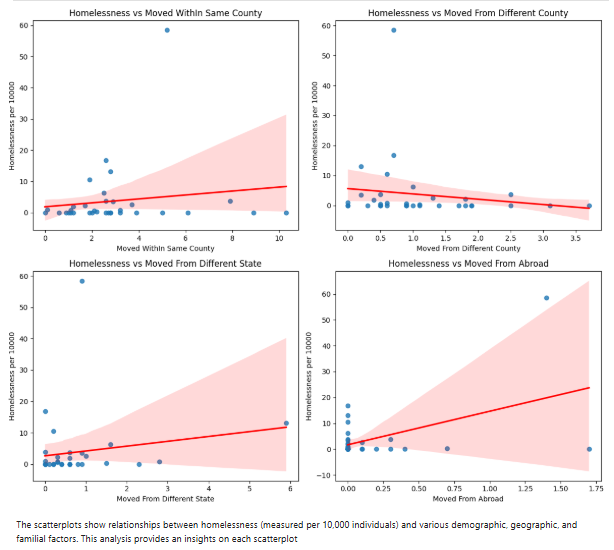

# Homelessness vs. Family Sturcture

Married Couple Families: The clear negative slope, shows that higher rates of married couple families are associated with lower homelessness. This could suggest that stable family structures provide economic and social support, reducing homelessness.

Male and Female Householders: The slight positive trend indicates that male-headed households may be correlated with high rates of homelessness, but much lesser than the rates associated with female Householder's scatterplot which reveals a stronger positive relationship. This potentially due to single-parent economic challenges.Female-headed households seem more vulnerable to homelessness, highlighting the intersection of poverty, caregiving roles, and gender inequities.

Single Parent Children: A positive slope suggests a strong relationship between the number of single-parent children and homelessness rates. This underscores how family instability can lead to economic vulnerability.

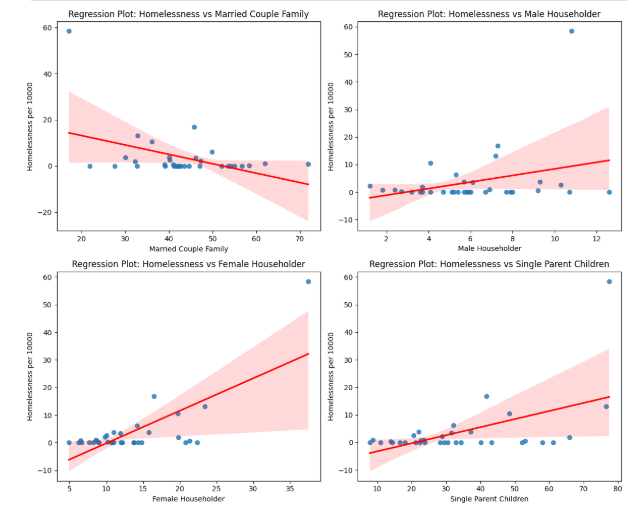

**ASCERTAINING TH EFEASIBILITY AND ACCEPTANCE OF SHARED HOUSING IN CAMDEN NJ**

Critics of shared housing argue that it may not be effective for certain populations due to cultural and personal factors, especially in societies with a strong emphasis on individualism, like the United States. However, due to increasing housing costs, shared housing seems to be on the rise as seen in this chart.   



In [ ]:
# Load municipality data and clean names
njMun = gpd.read_file('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Municipality.zip')
njMun.rename(columns={'NAMELSAD': 'Municipality'}, inplace=True)
njMun.loc[:, 'Municipality'] = njMun['Municipality'].str.strip().str.lower()

# Standardize and remove suffixes from municipality names but preserve Berlin distinctions
def clean_municipality_name(name):
    if 'berlin borough' in name or 'berlin township' in name:
        return name.lower().strip()
    # Clean other municipality names
    return re.sub(r'\s(borough|township|city|village|town)$', '', name, flags=re.IGNORECASE).strip().lower()

njMun['Municipality'] = njMun['Municipality'].apply(clean_municipality_name)





In [ ]:


# Load municipality data and clean names
njMun = gpd.read_file('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Municipality.zip')
njMun.rename(columns={'NAMELSAD': 'Municipality'}, inplace=True)
njMun['Municipality'] = njMun['Municipality'].str.strip().str.lower()

# Standardize municipality names while preserving Berlin distinctions
def clean_municipality_name(name):
    if 'berlin borough' in name:
        return 'berlin borough'
    if 'berlin township' in name:
        return 'berlin township'
    return re.sub(r'\s(borough|township|city|village|town)$', '', name, flags=re.IGNORECASE).strip().lower()

# Apply cleaning to municipality data
njMun['Municipality'] = njMun['Municipality'].apply(clean_municipality_name)

# Load and clean Family Household data
Family_Households = pd.read_excel('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Median%20Income%202022.xlsx')
Family_Households['Municipality'] = Family_Households['Municipality'].str.strip().str.lower()
Family_Households['Municipality'] = Family_Households['Municipality'].apply(clean_municipality_name)
Family_Households['Family Households'] = Family_Households['Family Households'].replace({'%': '', ',': ''}, regex=True)
Family_Households['Family Households'] = pd.to_numeric(Family_Households['Family Households'], errors='coerce')

# Load and clean Non-Family Household data
Nonfamily_Households = pd.read_excel('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Median%20Income%202022.xlsx')
Nonfamily_Households['Municipality'] = Nonfamily_Households['Municipality'].str.strip().str.lower()
Nonfamily_Households['Municipality'] = Nonfamily_Households['Municipality'].apply(clean_municipality_name)
Nonfamily_Households['Nonfamily Households'] = Nonfamily_Households['Nonfamily Households'].replace({'\$': '', ',': ''}, regex=True)
Nonfamily_Households['Nonfamily Households'] = pd.to_numeric(Nonfamily_Households['Nonfamily Households'], errors='coerce')

# Outer merge Family and Non-Family data with indicator
combined_data = pd.merge(
    Family_Households[['Municipality', 'Family Households']],
    Nonfamily_Households[['Municipality', 'Nonfamily Households']],
    on='Municipality',
    how='outer',
    indicator=True
)

# Debugging: Check for Berlin entries
print(combined_data[combined_data['Municipality'].str.contains('berlin')])

# Filter and normalize data
combined_data = combined_data.dropna(subset=['Family Households', 'Nonfamily Households'])  # Drop rows with missing data
combined_data['Total Households'] = combined_data['Family Households'] + combined_data['Nonfamily Households']
combined_data['Family Households'] = (combined_data['Family Households'] / combined_data['Total Households']) * 100
combined_data['Nonfamily Households'] = (combined_data['Nonfamily Households'] / combined_data['Total Households']) * 100

# Verify that both Berlins are included
print("Unique municipalities:", combined_data['Municipality'].unique())

# Create a stacked bar chart
plt.figure(figsize=(12, 6))
plt.bar(combined_data['Municipality'], combined_data['Family Households'], label='Family Households', color='skyblue')
plt.bar(combined_data['Municipality'], combined_data['Nonfamily Households'], bottom=combined_data['Family Households'], label='Nonfamily Households', color='orange')

# Add labels and title
plt.xlabel('Municipality')
plt.ylabel('Percentage (%)')
plt.title('Family vs Non-Family Households in Camden Municipalities')
plt.xticks(rotation=90)
plt.legend()

# Display the chart
plt.tight_layout()
plt.show();


In [ ]:
print(njMun[njMun['Municipality'].str.contains('Berlin')])


**HOUSING AND INCOME AS INUS CONDITION FOR HOMELESSNESS**

In the context of homelessness, housing and income can act individually and collectively as Insufficient but Necessary parts of Unnecessary but Sufficient conditions that contribute to Homelessness. Alone, neither of them as necessarily causes homelessness, as individuals may have support systems or temporary aids such as Housing Assistance, and other social safety nets. This Bar Chart shows how other risk factors, when interacting, significantly increases the vulnerability to homelessness, and each factor could be necessary within a particular combination but not sufficient on its own.

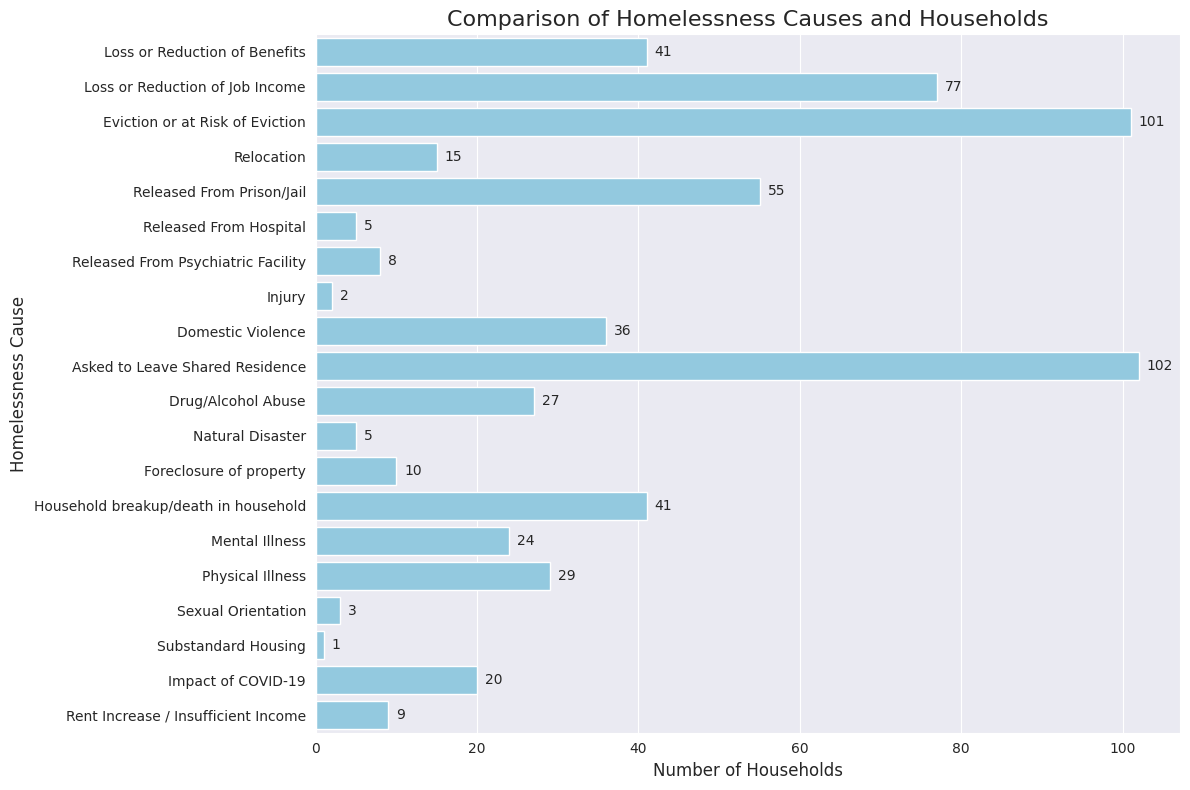

In [135]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the provided URL
url = 'https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/inus%20condition1.xlsx'
data = pd.read_excel(url)

# Set up the figure size
plt.figure(figsize=(12, 8))

# Create a horizontal bar chart using Seaborn
sns.barplot(
    data=data,
    y='Homelessness Cause ',  # Causes on the Y-axis for better label alignment
    x='Households',
    color='skyblue'
)

# Add labels for each bar
for index, value in enumerate(data['Households']):
    plt.text(value + 1, index, f'{value}', va='center')  # Annotate each bar

# Customize the chart
plt.title('Comparison of Homelessness Causes and Households', fontsize=16)
plt.xlabel('Number of Households', fontsize=12)
plt.ylabel('Homelessness Cause', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show();


**Findings from Yinghua et. al. (2008) **


Shared housing does not appear to affect its users adversely
in most of the dimensions we examined. On the contrary,
in some dimensions it appears to help. Sharing at
3 months is associated with less psychotic symptomology
at12 months. The idea that sharing reduces psychoticsymptomology
has intuitive appeal. Isolation leads people to
dwell on their own internal thinking, while having contact
with others fosters a focus on the interpersonal socialized
world.

**Landlord Engagement**

Landlord engagement can effectively promote shared housing despite policy limitations by implementing several strategies:

Financial incentives: Offering landlords financial rewards, such as signing bonuses or damage mitigation funds, can encourage them to participate in shared housing programs13. These incentives can help offset perceived risks associated with renting to multiple tenants.

Education and support: Providing landlords with training and resources on shared housing can help them understand the benefits and address concerns. This includes workshops on tenant-landlord laws, conflict resolution, and strategies for fostering positive relationships between roommates.

Roommate matching services: Housing organizations can facilitate roommate pairing to reduce housing costs and increase affordability for tenants4. This approach can make shared housing more attractive to both landlords and tenants.
Responsive customer service: Offering dedicated support to landlords, including assistance with inspection processes and timely payments, can build trust and long-term partnerships.
Risk mitigation: Implementing programs that provide landlords with support in case of income loss during move-in delays or damages can alleviate concerns about renting to multiple tenants.

Emphasizing stability: Highlighting the benefits of consistent rental payments through housing vouchers and ongoing case management support for tenants can make shared housing more appealing to landlords